## Table of Contents:  <a class="anchor" id="contents"></a>
* [Imports](#Imports)
* [Processing and Importing Dataframes](#processing)
* [Correlations and Accuracy](#correlations)
* [10%](#10)
* [20%](#20)
* [50%](#50)

## Imports <a class="anchor" id="Imports"></a>
[ToC](#contents)

In [80]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from   matplotlib import dates
from   IPython.core.display import HTML
import numpy as np
from   datetime import datetime, timedelta
from   pandas.tseries.offsets import *
DateFormatter

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Processing and Importing Dataframes  <a class="anchor" id="processing"></a>
[ToC](#contents)

In [49]:
# Read in Dataframes
dfReuters = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/New Merged Sentiment Reuters.csv')
dfMW = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/New Merged Sentiment MW.csv')
dfTMF = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/New Merged Sentiment TMF.csv')

dfsentimentFrames = [dfReuters, dfMW, dfTMF]
dfsentiment = pd.concat(dfsentimentFrames)
dfsentiment = dfsentiment.groupby(['Date','Company']).mean().reset_index()

dfticker = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Company Ticker.csv')
dfreturns = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Returns.csv')

# Change datetime
dfsentiment['Date'] = pd.to_datetime(dfsentiment['Date'])
# Add 1 normal day
dfsentiment['Date'] += timedelta(days=1)
dfreturns['Date'] = pd.to_datetime(dfreturns['prd'].astype(str), format='%Y%m%d')
lst = pd.bdate_range(start = '2015-02-03', end = '2021-06-16').tolist()

# Drop redundant columns
dfticker = dfticker.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
dfreturns = dfreturns.drop(['Unnamed: 0', 'prd'], axis = 1)
dfreturns = dfreturns[['Date', 'int_tick', 'tret']]
dfsentiment = dfsentiment.drop(['Unnamed: 0'], axis = 1)

# Rename columns
dfticker = dfticker.rename(columns={'Company Name': 'Company'})
dfreturns = dfreturns.rename(columns={'int_tick': 'Ticker', 'tret': 'Return'})

# Map Tickers and Returns onto dfsentiment
dfsentiment = dfsentiment.merge(dfticker, how='left').merge(dfreturns, how='left')

# Calculate Average Sentiment and Rolling mean (yday + today)
dfsentiment['Average'] = dfsentiment[['LMD', 'FinBERT', 'VADER', 'HIV4']].mean(axis=1, skipna=True).dropna()
dfsentiment = dfsentiment[['Date', 'Company', 'Ticker', 'LMD', 'HIV4', 'VADER', 'FinBERT','Average', 'Return']]

# Remove weekends and companies not in Investable Universe
dfsentiment = dfsentiment[dfsentiment['Date'].dt.weekday < 5] # Remove weekends
no_return_list = list(dfsentiment[dfsentiment['Ticker'].isna()]['Company'].unique()) # Remove companies not in IU
dfsentiment = dfsentiment[~dfsentiment['Company'].isin(no_return_list)]
dfsentiment = dfsentiment.dropna(subset=['Return'])

In [50]:
dfsentiment.nunique()

Date         1638
Company       417
Ticker        417
LMD         31930
HIV4        41493
VADER       21091
FinBERT     70132
Average    103432
Return     254425
dtype: int64

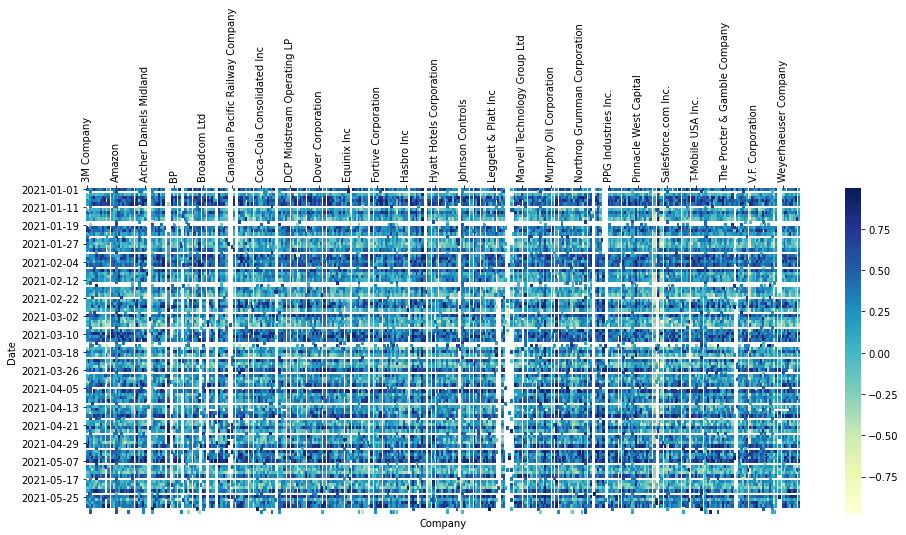

In [51]:
dfsentiment2 = dfsentiment[['Date', 'Company', 'Average']]
dfsentiment2 = dfsentiment2[~(dfsentiment2['Date'] < '2021-01-01')]

dfsentiment2['Date'] = pd.to_datetime(dfsentiment2['Date'], utc=True).dt.date 
dfsentiment2 = pd.pivot_table(dfsentiment2, index=["Date"],columns="Company",values="Average")
ax = sn.heatmap(dfsentiment2, cmap="YlGnBu")
ax.xaxis.tick_top()
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(16, 6)

## Correlations and Accuracy  <a class="anchor" id="correlations"></a>
[ToC](#contents)

In [52]:
correlations = dfsentiment.corr().unstack().sort_values(ascending=False) # Build correlation matrix
correlations = pd.DataFrame(correlations).reset_index() # Convert to dataframe
correlations.columns = ['Return', 'Method', 'Correlation with Returns'] # Label it
result2 = correlations.query("Return == 'Return' & Method != 'Return'") # Filter by variable
result2 = result2.drop(['Return'], axis = 1)

result2

,Method,Correlation with Returns
26,Average,0.022916
28,VADER,0.019249
30,FinBERT,0.018651
33,LMD,0.017388
35,HIV4,0.013684


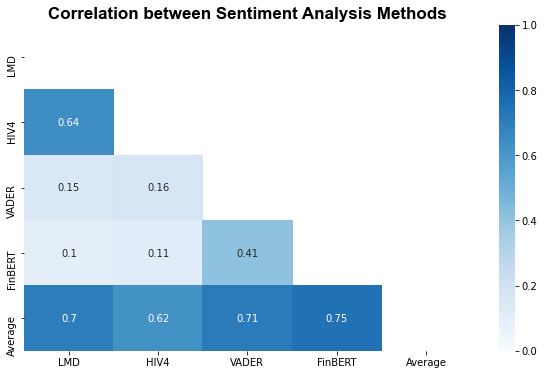

In [53]:
dfMethodCorrelation = pd.DataFrame(dfsentiment,columns=['LMD','HIV4','VADER', 'FinBERT', 'Average'])
corrMatrixPearson = dfMethodCorrelation.corr()
mask = np.triu(corrMatrixPearson)
sn.heatmap(corrMatrixPearson, annot=True, vmin=0, vmax=1, cmap="Blues", mask=mask)
plt.title("Correlation between Sentiment Analysis Methods", fontname="arial", fontsize=17, fontweight="bold")
fig = plt.gcf()
fig.set_size_inches(10, 6)

## 10% Portfolio  <a class="anchor" id="10"></a>
[ToC](#contents)

In [54]:
list_methods = ['LMD','HIV4','VADER', 'FinBERT', 'Average']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1, dict_ret2, dict_ret3, dict_ret4, dict_ret5]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna(subset=[list_methods[x]])
        total_return = 0
        total_count = 0

        large_df = sample_df.nlargest(int(0.1 * len(sample_df)), list_methods[x])
        small_df = sample_df.nsmallest(int(0.1 * len(sample_df)), list_methods[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0: 
            total_ret_long = total_ret_long / count_long 

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][lst[i]] = total_return

In [55]:
newportfolio10 = pd.DataFrame(dict_ret).transpose()
newportfolio10 = newportfolio10.rename(columns={0: 'LMD', 1: 'HIV4', 2: 'VADER', 3: 'FinBERT', 4:'Average'})
newportfolio10.to_csv('10percentportfolio.csv')

<AxesSubplot:title={'center':'MSTD(30) Returns of Long-Short (10%) Portfolio'}, xlabel='Date', ylabel='MSTD Returns (%)'>

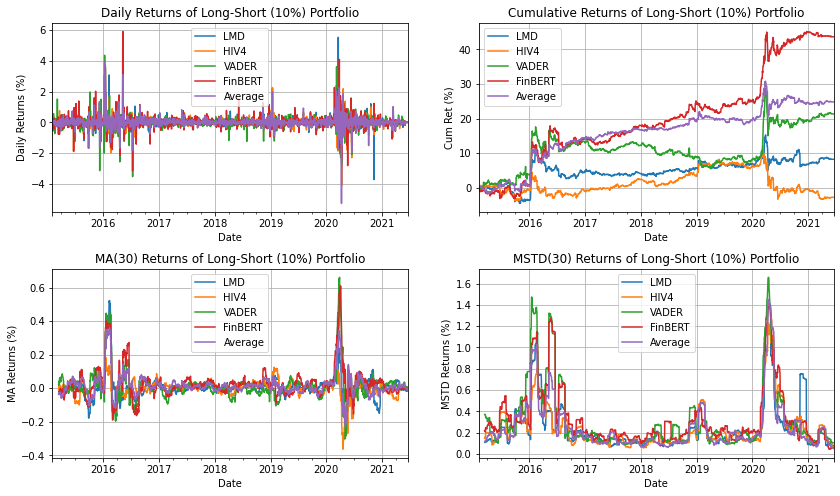

In [56]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(14,8))
plt.subplots_adjust(hspace=0.3)
newportfolio10.plot(ax=ax1, title='Daily Returns of Long-Short (10%) Portfolio', xlabel='Date', ylabel='Daily Returns (%)', grid=True)
newportfolio10.cumsum().plot(ax=ax2, title='Cumulative Returns of Long-Short (10%) Portfolio', xlabel='Date', ylabel='Cum Ret (%)', grid=True)
newportfolio10.rolling(30).mean().plot(ax=ax3, title='MA(30) Returns of Long-Short (10%) Portfolio', xlabel='Date', ylabel='MA Returns (%)', grid=True)
newportfolio10.rolling(30).std().plot(ax=ax4, title='MSTD(30) Returns of Long-Short (10%) Portfolio', xlabel='Date', ylabel='MSTD Returns (%)', grid=True)

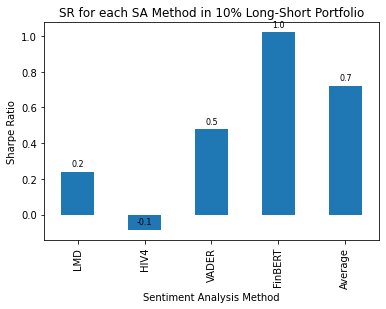

In [66]:
newportfolio10 = pd.read_csv('10percentportfolio.csv')
newportfolio10 = newportfolio10.rename(columns={'Unnamed: 0': 'Date'})
# newportfolio10 = newportfolio10[~(newportfolio10['Date'] < '2019-01-01')]
methodreturn = newportfolio10[['LMD','HIV4','VADER', 'FinBERT', 'Average']]

mean_return = methodreturn.mean()
std_return = methodreturn.std()
businessDays = 262
annual_factor = np.sqrt(businessDays)
SR = (mean_return*annual_factor)/(std_return)

plots = SR.plot.bar(title='SR for each SA Method in 10% Long-Short Portfolio')
plt.xlabel("Sentiment Analysis Method", size=10)
plt.ylabel("Sharpe Ratio", size=10)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

## 20% Porfolio  <a class="anchor" id="20"></a>
[ToC](#contents)

In [58]:
list_methods = ['LMD','HIV4','VADER', 'FinBERT', 'Average']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1, dict_ret2, dict_ret3, dict_ret4, dict_ret5]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna(subset=[list_methods[x]])
        total_return = 0
        total_count = 0

        large_df = sample_df.nlargest(int(0.2 * len(sample_df)), list_methods[x])
        small_df = sample_df.nsmallest(int(0.2 * len(sample_df)), list_methods[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0: 
            total_ret_long = total_ret_long / count_long 

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][lst[i]] = total_return

In [59]:
newportfolio20 = pd.DataFrame(dict_ret).transpose()
newportfolio20 = newportfolio20.rename(columns={0: 'LMD', 1: 'HIV4', 2: 'VADER', 3: 'FinBERT', 4:'Average'})
newportfolio20.to_csv('20percentportfolio.csv')
# newportfolio20 = newportfolio20.set_index('Date')

<AxesSubplot:title={'center':'MSTD(30) Returns of Long-Short (20%) Portfolio'}, xlabel='Date', ylabel='MSTD Returns (%)'>

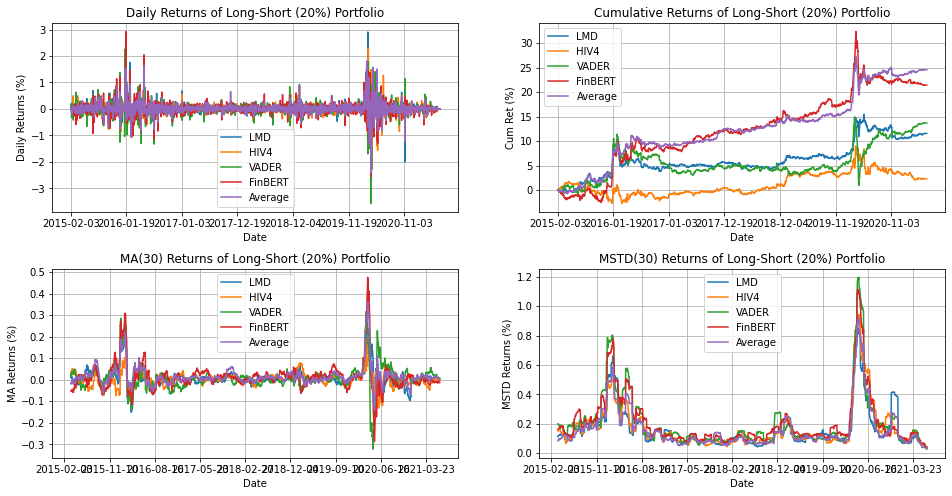

In [112]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(16,8))
plt.subplots_adjust(hspace=0.3)
newportfolio20.plot(ax=ax1, title='Daily Returns of Long-Short (20%) Portfolio', xlabel='Date', ylabel='Daily Returns (%)', grid=True)
newportfolio20.cumsum().plot(ax=ax2, title='Cumulative Returns of Long-Short (20%) Portfolio', xlabel='Date', ylabel='Cum Ret (%)', grid=True)
newportfolio20.rolling(30).mean().plot(ax=ax3, title='MA(30) Returns of Long-Short (20%) Portfolio', xlabel='Date', ylabel='MA Returns (%)', grid=True)
newportfolio20.rolling(30).std().plot(ax=ax4, title='MSTD(30) Returns of Long-Short (20%) Portfolio', xlabel='Date', ylabel='MSTD Returns (%)', grid=True)

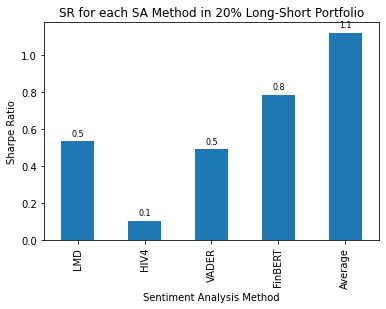

In [67]:
newportfolio20 = pd.read_csv('20percentportfolio.csv')
newportfolio20 = newportfolio20.rename(columns={'Unnamed: 0': 'Date'})
methodreturn = newportfolio20[['LMD','HIV4','VADER', 'FinBERT', 'Average']]

annual_factor = np.sqrt(262)
SR = (methodreturn.mean()*annual_factor)/(methodreturn.std())

plots = SR.plot.bar(title='SR for each SA Method in 20% Long-Short Portfolio')
plt.xlabel("Sentiment Analysis Method", size=10)
plt.ylabel("Sharpe Ratio", size=10)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

## 50% Portfolio  <a class="anchor" id="50"></a>
[ToC](#contents)

In [62]:
list_methods = ['LMD','HIV4','VADER', 'FinBERT', 'Average']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1, dict_ret2, dict_ret3, dict_ret4, dict_ret5]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna(subset=[list_methods[x]])
        total_return = 0
        total_count = 0

        large_df = sample_df.nlargest(int(0.5 * len(sample_df)), list_methods[x])
        small_df = sample_df.nsmallest(int(0.5 * len(sample_df)), list_methods[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0: 
            total_ret_long = total_ret_long / count_long 

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][lst[i]] = total_return

In [63]:
newportfolio50 = pd.DataFrame(dict_ret).transpose()
newportfolio50 = newportfolio50.rename(columns={0: 'LMD', 1: 'HIV4', 2: 'VADER', 3: 'FinBERT', 4:'Average'})
newportfolio50.to_csv('50percentportfolio.csv')

<AxesSubplot:title={'center':'MSTD(30) Returns of Long-Short (50%) Portfolio'}, xlabel='Date', ylabel='MSTD Returns (%)'>

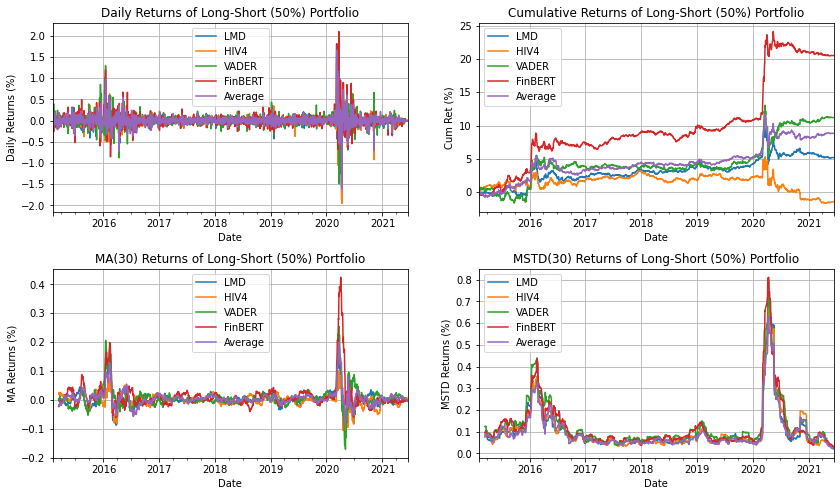

In [64]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(14,8))
plt.subplots_adjust(hspace=0.3)
newportfolio50.plot(ax=ax1, title='Daily Returns of Long-Short (50%) Portfolio', xlabel='Date', ylabel='Daily Returns (%)', grid=True)
newportfolio50.cumsum().plot(ax=ax2, title='Cumulative Returns of Long-Short (50%) Portfolio', xlabel='Date', ylabel='Cum Ret (%)', grid=True)
newportfolio50.rolling(30).mean().plot(ax=ax3, title='MA(30) Returns of Long-Short (50%) Portfolio', xlabel='Date', ylabel='MA Returns (%)', grid=True)
newportfolio50.rolling(30).std().plot(ax=ax4, title='MSTD(30) Returns of Long-Short (50%) Portfolio', xlabel='Date', ylabel='MSTD Returns (%)', grid=True)

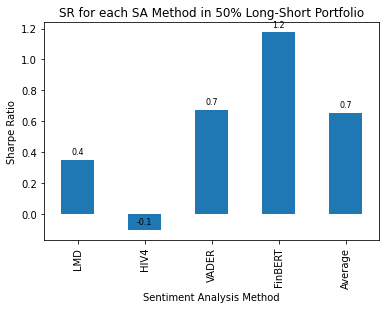

In [65]:
newportfolio50 = pd.read_csv('50percentportfolio.csv')
newportfolio50 = newportfolio50.rename(columns={'Unnamed: 0': 'Date'})
methodreturn = newportfolio50[['LMD','HIV4','VADER', 'FinBERT', 'Average']]

annual_factor = np.sqrt(262)
SR = (methodreturn.mean()*annual_factor)/(methodreturn.std())

plots = SR.plot.bar(title='SR for each SA Method in 50% Long-Short Portfolio')
plt.xlabel("Sentiment Analysis Method", size=10)
plt.ylabel("Sharpe Ratio", size=10)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')